In [87]:
import os
import random
import matplotlib.pyplot as plt
import statistics
import numpy
import yaml

# https://retirementplans.vanguard.com/VGApp/pe/pubeducation/calculators/RetirementNestEggCalc.jsf


In [88]:
!{sys.executable} -m pip install PyYAML


shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
Fatal Python error: pymain_compute_path0: memory allocation failed
ValueError: character U+ec6482a0 is not in range [U+0000; U+10ffff]

Current thread 0x000000010ad0d5c0 (most recent call first):


In [89]:
def load_personal_finance(expanduser):
    personal_finance = {}
    personal_finance_path = expanduser
    if os.path.exists(personal_finance_path):
        with open(personal_finance_path) as f:
            personal_finance = yaml.safe_load(f)
        print(personal_finance)
    return personal_finance


In [90]:
current_age = 25
retire_age = 50
end_of_life_age = 90

post_tax_current_savings = 100_000 
yearly_post_tax_and_benefits_income = 100_000 
yearly_post_tax_and_benefits_spend = 100_000

tax_deferred_current_savings=20_000
tax_deferred_yearly_savings=19_000
tax_deferred_employer_matching_rate = 1
tax_deferred_maximum_of_federal_limit = 0.035
tax_deferred_federal_limit = 280_000 

tax_free_current_savings =5_000
tax_free_yearly_savings	 =26_000

tax_rate = 0.30
post_tax_to_tax_deferred_adj = 1/(1 - tax_rate)

inflation = lambda : random.randint(1,7)/100
rate_of_return = lambda : random.randint(4,12)/100

simulations = 100


# update with values from personal_finance
# personal_finance = load_personal_finance(os.path.expanduser("~/personal_finance.yaml"))
# for k,v in personal_finance.items():
#     globals()[k] = v
#     print(post_tax_current_savings)


In [91]:
def subtract(amount: int, 
             post_tax_to_tax_deferred_adj: float, 
             step: int, 
             post_tax_balance: numpy.ndarray, 
             tax_deferred_balance: numpy.ndarray, 
             tax_free_balance: numpy.ndarray):
    if post_tax_balance[step] > 0:
        post_tax_balance[step] -= amount
        if post_tax_balance[step] > 0:
            amount = 0
        else:
            amount = abs(post_tax_balance[step])
            post_tax_balance[step] = 0
    
    if tax_deferred_balance[step] > 0: 
        tax_deferred_balance[step] -= amount * post_tax_to_tax_deferred_adj
        if tax_deferred_balance[step] > 0:
            amount = 0
        else:
            amount = abs(tax_deferred_balance[step])
            tax_deferred_balance[step] = 0

    if tax_free_balance[step] > 0: 
        tax_free_balance[step] -= amount
        if tax_free_balance[step] > 0:
            amount = 0
        else:
            amount = abs(tax_free_balance[step])
            tax_free_balance[step] = 0


In [92]:
steps = end_of_life_age - current_age
sims = numpy.zeros((simulations,steps))

for sim in range(simulations):
    post_tax_balance = numpy.zeros(steps)
    post_tax_balance[0] = post_tax_current_savings
    
    tax_deferred_balance = numpy.zeros(steps)
    tax_deferred_balance[0] = tax_deferred_current_savings
    
    tax_free_balance = numpy.zeros(steps)
    tax_free_balance[0] = tax_free_current_savings
    
    for step in range(1, steps):
        retired = (step + current_age) >= retire_age 
        this_year_rate_of_return = rate_of_return()
        
        post_tax_interest = post_tax_balance[step - 1] * this_year_rate_of_return
        tax_on_post_tax_interest = post_tax_interest * tax_rate
        post_tax_yearly_change = post_tax_interest + \
                        - tax_on_post_tax_interest + \
                        (yearly_post_tax_and_benefits_income if not retired else 0)
        
        tax_deferred_yearly_employer_contributions = min(
            tax_deferred_yearly_savings * tax_deferred_employer_matching_rate, 
            tax_deferred_maximum_of_federal_limit * tax_deferred_federal_limit)
        
        tax_deferred_yearly_change = tax_deferred_balance[step - 1] * this_year_rate_of_return + \
                                     (tax_deferred_yearly_savings if not retired else 0) + \
                                     (tax_deferred_yearly_employer_contributions if not retired else 0)
        
        tax_free_yearly_change = tax_free_balance[step - 1] * this_year_rate_of_return
        
        post_tax_balance[step] = post_tax_balance[step - 1] + post_tax_yearly_change
        tax_deferred_balance[step] = tax_deferred_balance[step - 1] + tax_deferred_yearly_change
        tax_free_balance[step] = tax_free_balance[step - 1] +  tax_deferred_yearly_change
       
        subtract(yearly_post_tax_and_benefits_spend, 
                 post_tax_to_tax_deferred_adj, 
                 step, 
                 post_tax_balance, 
                 tax_deferred_balance, 
                 tax_free_balance)
    
    sims[sim] = post_tax_balance + tax_deferred_balance + tax_free_balance

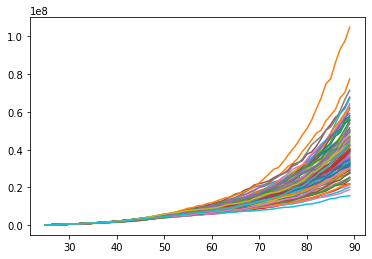

In [93]:
for sim in range(simulations):
    plt.plot(range(current_age, end_of_life_age), sims[sim])

# plt.ylabel('Player Money in $')
# plt.xlabel('Number of bets')


40717142.047702305


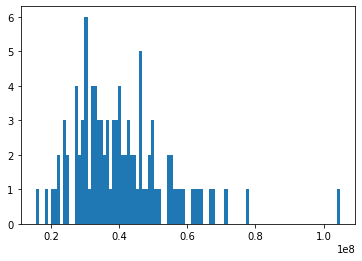

In [94]:
outcomes = sims[:, -1]
h = plt.hist(outcomes, bins=100)
print(statistics.mean(outcomes))